## Les Pré-travaux

In [1]:
## Les Pré-travaux
import pandas as pd
## Pour une affiche plus large de certaines sorties
# Augmenter la largeur d'affichage pour voir toutes les colonnes
pd.set_option('display.max_columns', None)

# Augmenter le nombre de lignes affichées
pd.set_option('display.max_rows', None)

# Désactiver la coupure du texte
pd.set_option('display.max_colwidth', None)

In [14]:
# Pour la reproductibilité (fixer le germe)

import random
import numpy as np
import sklearn

def set_seed_sklearn(seed: int = 42):
    random.seed(seed)                 # Graine Python
    np.random.seed(seed)             # Graine NumPy
    try:
        sklearn.utils.check_random_state(seed) # pour les modèles sklearn utilisant joblib (random forests, etc)
    except:
        pass

# Utilisation
set_seed_sklearn(42)


In [3]:
!pip install ucimlrepo


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

df = pd.concat([X, y], axis=1)

# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
df.head()

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [24]:
# Encodage de la variable cible : M = 1, B = 0
y=df['Diagnosis'] = df['Diagnosis'].map({'M': 0, 'B': 1})

# Vérification rapide
print(df['Diagnosis'].value_counts())

Diagnosis
1    357
0    212
Name: count, dtype: int64


# Partie 2: Implémentation d'un clustering sur la partie des caractéristiques de notre jeu de donnée

## I. Détermination des hyperparamètres optimales 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

def find_k_and_eps(df, k_max=10, min_pts_ratio=2.5, sample_max=2000, display=True):


    X = StandardScaler().fit_transform(df.values)



    if len(X) > sample_max:
        idx = np.random.choice(len(X), sample_max, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X

    inertias, silhouettes, davies_bouldin = [], [], []
    K_values = range(2, k_max + 1)

    #  Recherche du meilleur K pour KMeans
    for k in K_values:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
        labels = kmeans.fit_predict(X_sample)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_sample, labels))
        davies_bouldin.append(davies_bouldin_score(X_sample, labels))

    k_opt = K_values[int(np.argmax(silhouettes))] # Prends la valeur de K qui a donné le meilleur score silhouette

    #  Recherche de eps optimal pour DBSCAN
    minPts = int(df.shape[1] * min_pts_ratio)
    neigh = NearestNeighbors(n_neighbors=minPts, n_jobs=-1)
    nbrs = neigh.fit(X_sample)
    distances, _ = nbrs.kneighbors(X_sample)
    k_distances = np.sort(distances[:, -1])

    # Détection automatique du coude
    i = np.arange(len(k_distances))
    p1 = np.array([0, k_distances[0]])
    p2 = np.array([len(k_distances) - 1, k_distances[-1]])
    distance_to_line = np.abs(np.cross(p2 - p1, np.vstack((i, k_distances)).T - p1)) / np.linalg.norm(p2 - p1)
    eps_optimal = k_distances[np.argmax(distance_to_line)]

    #  Visualisation
    if display:
        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.plot(K_values, inertias, 'o-', label='Inertie')
        plt.axvline(k_opt, color='r', linestyle='--', label=f'K optimal = {k_opt}')
        plt.title("Méthode du coude (Inertie)")
        plt.xlabel("K")
        plt.ylabel("Inertie")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(K_values, silhouettes, 'o-', color='green', label='Silhouette')
        plt.axvline(k_opt, color='r', linestyle='--')
        plt.title("Score Silhouette")
        plt.xlabel("K")
        plt.ylabel("Silhouette")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(K_values, davies_bouldin, 'o-', color='orange', label='Davies-Bouldin')
        plt.axvline(k_opt, color='r', linestyle='--')
        plt.title("Indice Davies-Bouldin (plus petit = meilleur)")
        plt.xlabel("K")
        plt.ylabel("Score")
        plt.legend()

        plt.tight_layout()
        plt.show()

        # k-distance
        plt.figure(figsize=(6, 4))
        plt.plot(k_distances)
        plt.axhline(y=eps_optimal, color='r', linestyle='--', label=f"ε optimal = {eps_optimal:.4f}")
        plt.title(f"Courbe k-distance (minPts = {minPts})")
        plt.xlabel("Points triés")
        plt.ylabel(f"Distance au {minPts}ᵉ voisin")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Affichage
    print(f" K optimal trouvé : {k_opt}")
    print(f" Epsilon optimal trouvé : {eps_optimal:.4f}")
    print(f" minPts utilisé : {minPts}")

    return k_opt, eps_optimal


Nous allons écrire une fonction pour déterminer k et eps

Même si nous savons que k=2, nous somme currieux de savoir lequel est identifié par la méthode de coude comme étant l'optimal

C:\Users\MEHOUN MARTINIEN\AppData\Local\Temp\ipykernel_18572\2110152141.py:46: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  distance_to_line = np.abs(np.cross(p2 - p1, np.vstack((i, k_distances)).T - p1)) / np.linalg.norm(p2 - p1)


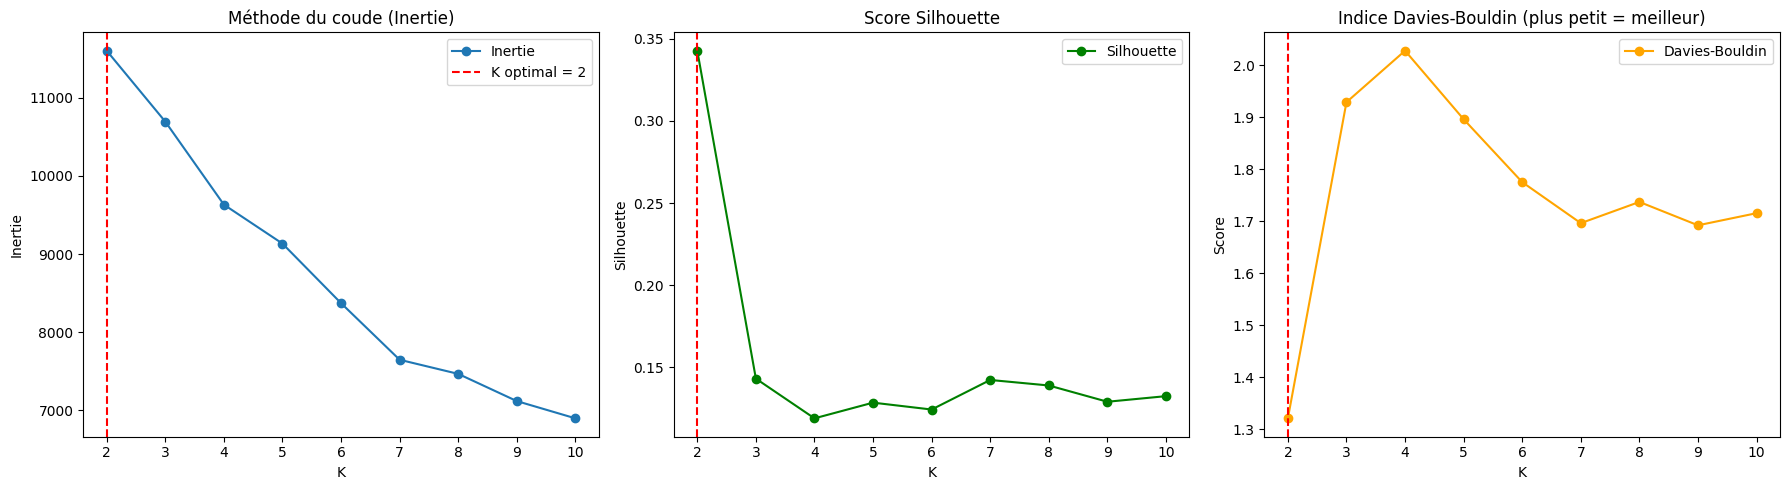

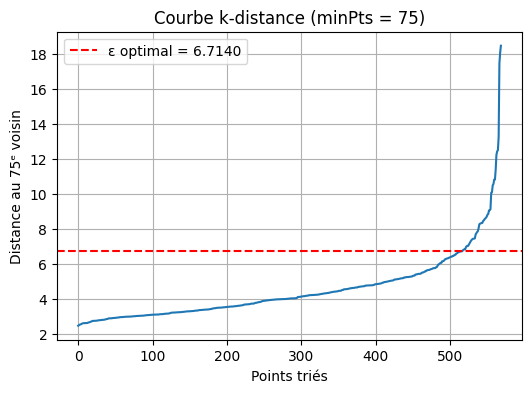

 K optimal trouvé : 2
 Epsilon optimal trouvé : 6.7140
 minPts utilisé : 75
K optimal = 2
Epsilon optimal = 6.7140462751456065


In [26]:
k, eps = find_k_and_eps(X,sample_max=569)
print("K optimal =", k)
print("Epsilon optimal =", eps)

Interprétation des résultats :

Sur le graphique du score Silhouette, la valeur maximale semble se situer autour de k=2 (score d'environ 0.30-0.35), ce qui confirme que k=2 est optimal car un score plus proche de 1 indique de meilleurs clusters.

Pour l'indice Davies-Bouldin, la valeur minimale apparaît également vers k=2, ce qui est cohérent puisque pour cet indice, plus la valeur est faible, meilleure est la séparation entre les clusters.

Ainsi, les trois métriques convergent :

Méthode du coude : k=2

Score Silhouette maximal : k=2

Indice Davies-Bouldin minimal : k=2

Conclusion : k=2 est clairement le choix optimal.

Cependant, k=7 est un candidat potentiel.

Sur le graphique d'inertie (méthode du coude), on observe un premier coude marqué à k=2, mais un second coude subtil apparaît vers k=7, où la décroissance de l'inertie ralentit à nouveau.

Pour le score Silhouette, bien que le maximum absolu soit à k=2, la valeur pour k=7 reste relativement correcte (environ 0.15-0.20), ce qui n'est pas négligeable.

L'indice Davies-Bouldin montre également une valeur basse pour k=7, comparable à d'autres k intermédiaires.

k=7 pourrait donc être un bon compromis mais pour notre étude , le domaine métier ne justifie pas  une segmentation plus fine.

Nous allons garder k=2 pour la suite de l'analyse.



## II. Comparaison de plusieurs algorithme de clustering 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import hdbscan
from scipy.spatial.distance import pdist, squareform

# Dunn Index 
def dunn_index(X, labels, max_points=3000):
    if len(X) > max_points:
        idx = np.random.choice(len(X), max_points, replace=False)
        X = X[idx]
        labels = labels[idx]
    distances = squareform(pdist(X))
    clusters = np.unique(labels)
    clusters = [c for c in clusters if c != -1]
    if len(clusters) < 2:
        return 0
    intra = max([np.max(distances[labels == c][:, labels == c]) for c in clusters])
    inter = np.min([
        distances[np.ix_(labels == c1, labels == c2)].min()
        for i, c1 in enumerate(clusters) for c2 in clusters[i + 1:]
    ])
    return inter / intra

#Stabilité
def stability_score(X, labels_func, runs=3, ratio=0.3):
    scores = []
    n = len(X)
    m = int(ratio * n)
    for _ in range(runs):
        idx1 = np.random.choice(n, m, replace=False)
        idx2 = np.random.choice(n, m, replace=False)
        l1 = labels_func(X[idx1])
        l2 = labels_func(X[idx2])
        min_len = min(len(l1), len(l2))
        s = np.mean(l1[:min_len] == l2[:min_len])
        scores.append(s)
    return np.mean(scores)




In [22]:
from sklearn.metrics import f1_score

def clustering_compare_full(X,y, k=2, eps=0.5, minPts=10,
                            algos=["kmeans", "dbscan", "hdbscan", "spectral"],
                            pca_components=None):
    print(" Standardisation des données...")
    X = StandardScaler().fit_transform(df.values)
    y_true = y  

    # PCA facultative
    if pca_components is not None and pca_components < X.shape[1]:
        print(f"Réduction PCA à {pca_components} composantes...")
        X = PCA(n_components=pca_components, random_state=42).fit_transform(X)

    results = {}
    print(" Exécution des algorithmes sur tout le dataset...")

    # KMeans
    if "kmeans" in algos:
        print(" MiniBatchKMeans...")
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096).fit(X)
        labels = kmeans.labels_
        results["KMeans"] = {
            "CH": calinski_harabasz_score(X, labels),
            "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
            "Dunn": dunn_index(X, labels),
            "Davies": davies_bouldin_score(X, labels),
            "Stability": stability_score(X, lambda data: MiniBatchKMeans(
                n_clusters=k, random_state=42, batch_size=4096).fit(data).labels_),
            "F1_macro": f1_score(y_true, labels, average="macro")  #
        }
        results["KMeans"]["labels"] = labels

    # DBSCAN
    if "dbscan" in algos:
        print(" DBSCAN...")
        dbs = DBSCAN(eps=eps, min_samples=minPts, n_jobs=-1).fit(X)
        labels = dbs.labels_
        if len(set(labels)) > 1:
            results["DBSCAN"] = {
                "CH": calinski_harabasz_score(X, labels),
                "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
                "Dunn": dunn_index(X, labels),
                "Davies": davies_bouldin_score(X, labels),
                "Stability": stability_score(X, lambda data: DBSCAN(
                    eps=eps, min_samples=minPts, n_jobs=-1).fit(data).labels_),
                "F1_macro": f1_score(y_true, labels, average="macro")  # 
            }
        else:
            results["DBSCAN"] = {"CH": 0, "Silhouette": 0, "Dunn": 0,
                                 "Davies": float("inf"), "Stability": 0,
                                 "F1_macro": 0}
        results["DBSCAN"]["labels"] = labels

    # HDBSCAN
    if "hdbscan" in algos:
        print(" HDBSCAN...")
        hdb = hdbscan.HDBSCAN(min_cluster_size=minPts, core_dist_n_jobs=-1).fit(X)
        labels = hdb.labels_
        if len(set(labels)) > 1:
            results["HDBSCAN"] = {
                "CH": calinski_harabasz_score(X, labels),
                "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
                "Dunn": dunn_index(X, labels),
                "Davies": davies_bouldin_score(X, labels),
                "Stability": stability_score(X, lambda data: hdbscan.HDBSCAN(
                    min_cluster_size=minPts, core_dist_n_jobs=-1).fit(data).labels_),
                "F1_macro": f1_score(y_true, labels, average="macro")  # 
            }
        else:
            results["HDBSCAN"] = {"CH": 0, "Silhouette": 0, "Dunn": 0,
                                  "Davies": float("inf"), "Stability": 0,
                                  "F1_macro": 0}
        results["HDBSCAN"]["labels"] = labels

    # Spectral
    if "spectral" in algos:
        print(" Spectral Clustering...")
        sp = SpectralClustering(
            n_clusters=k, affinity='nearest_neighbors',
            assign_labels='kmeans', random_state=42, n_jobs=-1
        ).fit(X)
        labels = sp.labels_
        results["Spectral"] = {
            "CH": calinski_harabasz_score(X, labels),
            "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
            "Dunn": dunn_index(X, labels),
            "Davies": davies_bouldin_score(X, labels),
            "Stability": stability_score(X, lambda data: SpectralClustering(
                n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans',
                random_state=42, n_jobs=-1).fit(data).labels_),
            "F1_macro": f1_score(y_true, labels, average="macro") 
        }
        results["Spectral"]["labels"] = labels

    # Nouvelle métrique affichée
    metrics = ["CH", "Silhouette", "Dunn", "Davies", "Stability", "F1_macro"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.bar(results.keys(), [results[a][metric] for a in results])
        plt.title(f"Comparaison des algorithmes - {metric}")
        plt.ylabel("Score")
        plt.show()

    best = max(results, key=lambda a: (
        results[a]["Silhouette"] + results[a]["CH"] + results[a]["Dunn"] + results[a]["Stability"]+ results[a]["F1_macro"]
        - results[a]["Davies"]
    ))
    print(f" Le meilleur algorithme est : {best}")
    best_labels = results[best]["labels"]

    return best, best_labels, results


 Standardisation des données...
Réduction PCA à 4 composantes...
 Exécution des algorithmes sur tout le dataset...
 MiniBatchKMeans...
 DBSCAN...
 HDBSCAN...


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 Spectral Clustering...


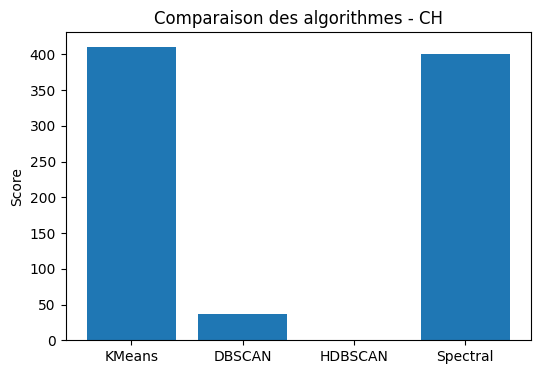

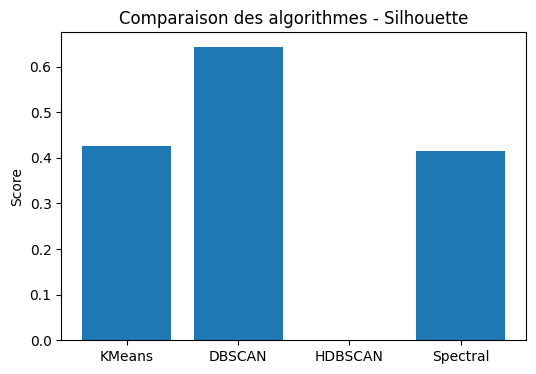

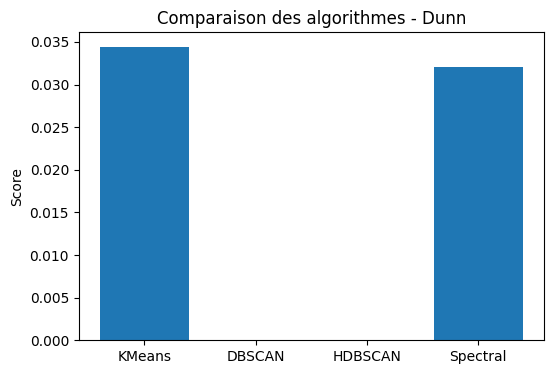

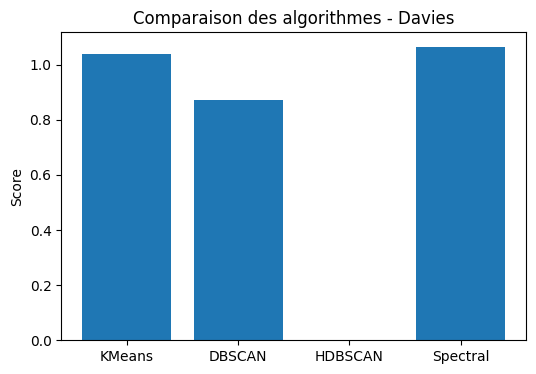

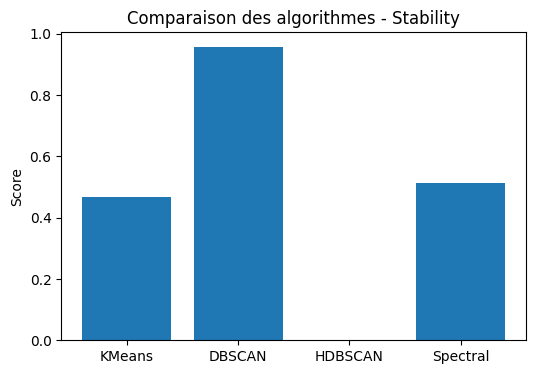

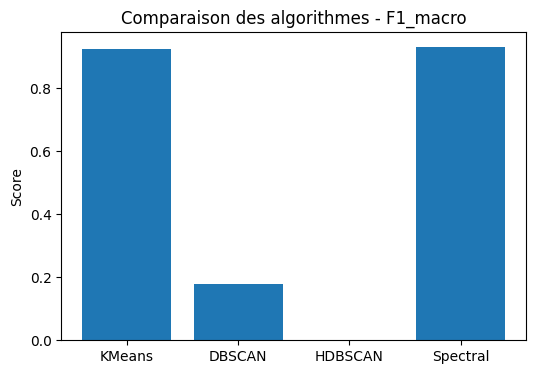

 Le meilleur algorithme est : KMeans


In [27]:
best, labels, results = clustering_compare_full(X,y, k=2, eps=6.714046275145607, minPts=75, pca_components=4)

# Partie 3: Apprentissage supervisé (classification)

Dans cette partie. Notre objectif est de prédire la cible Diagnosis à partir des caractéristiques de notre jeu de donnée

Nous allons refaire le chargement et la séparation des données en train et test

In [5]:
from ucimlrepo import fetch_ucirepo
import pandas as pd 

def chargement_donnees_ucirepo(test_size=0.2, random_state=42, target='Diagnosis'):
      # fetch dataset 
    breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
    
    # data (as pandas dataframes) 
    X = breast_cancer_wisconsin_diagnostic.data.features 
    y = breast_cancer_wisconsin_diagnostic.data.targets

    # remplace target binaire par une autre variable 'diagnostic'
    y = y.replace({"M": 1, "B": 0})



    df = pd.concat([X, y], axis=1)

    # metadata 
    print(breast_cancer_wisconsin_diagnostic.metadata) 
    
    # variable information 
    df.head()
    #séparation en train et test
    from sklearn.model_selection import train_test_split
    if target=='Diagnosis':
       train, test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['Diagnosis'])
    else:
       train, test = train_test_split(df, test_size=test_size, random_state=random_state)
     

    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    return df, train, test, X_train, y_train, X_test, y_test


In [6]:
df, train, test, X_train, y_train, X_test, y_test = chargement_donnees_ucirepo()

C:\Users\MEHOUN MARTINIEN\AppData\Local\Temp\ipykernel_18572\2571452646.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"M": 1, "B": 0})


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

## I. Modélisation

Nous allons utiliser plusieurs algorithmes de classification pour prédire si une tumeur est bénigne ou maligne en fonction des caractéristiques des cellules.

**KNN**

Utilisé car il classe efficacement les tumeurs en se basant sur la similarité des cellules, utile pour un dataset propre comme WDBC.

**Logistic Regression**

Choisi pour fournir une baseline médicale interprétable et des probabilités claires pour le diagnostic binaire.

**Decision Tree**

Retenu car il donne une décision compréhensible et visualisable, ce qui facilite l’explication clinique.

**Random Forest**

Sélectionné car il réduit fortement l’overfitting des arbres individuels et gère très bien les variables non linéaires du dataset.

**Gradient Boosting**

Employé pour sa capacité à corriger progressivement les erreurs et détecter des relations subtiles entre caractéristiques cellulaires.

**Bagging**

Utilisé pour stabiliser les prédictions d’arbres instables et améliorer la robustesse sur des données légèrement bruitées.

**AdaBoost**

Choisi car il met l’accent sur les cellules difficiles à classer, ce qui améliore la précision sur les cas borderline.

**XGBoost**

Retenu pour sa performance élevée, ses régularisations intégrées et sa capacité à gérer les interactions complexes entre features.

**LightGBM**

Privilégié pour sa rapidité d’entraînement et sa grande efficacité sur des données numériques tabulaires comme celles du WDBC.

**CatBoost**

Sélectionné car il gère naturellement les relations non linéaires et offre une grande stabilité sans réglages complexes.


## Explication du choix des hyperparamètres

**KNN (KNeighborsClassifier)**

Hyperparamètre choisi : n_neighbors=5.

Justification : Le choix de 5 voisins est un compromis classique. Avec moins de voisins (1-2), le modèle devient très sensible au bruit et aux outliers. Avec trop de voisins (>10), la prédiction se “lisse” trop et perd en précision locale. Cette valeur est souvent utilisée comme point de départ.

Référence : Documentation officielle de scikit-learn pour KNN : KNeighborsClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)



**Logistic Regression**

Hyperparamètres choisis : max_iter=3000, solver='lbfgs'.

Justification :

max_iter=3000 : valeur augmentée par rapport à la valeur par défaut (100) pour garantir la convergence sur des datasets avec plusieurs features standardisées.

solver='lbfgs' : adapté aux datasets de taille petite à moyenne et stable pour la classification binaire.

Référence : Documentation scikit-learn : LogisticRegression
.

Remarque : La valeur de max_iter n’a pas de recommandation stricte ; elle est choisie pour s’assurer que le modèle converge.




**Decision Tree**

Hyperparamètre choisi : max_depth=None.

Justification : L’arbre est autorisé à se développer entièrement pour capturer toutes les interactions entre features. C’est une approche classique pour un test initial afin de mesurer la capacité maximale du modèle.

Référence : Documentation scikit-learn : DecisionTreeClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
.

Remarque : Aucune référence précise pour la profondeur illimitée, c’est un choix pratique pour tester la capacité maximale.



**Random Forest**

Hyperparamètres choisis : n_estimators=200, random_state=42.

Justification :

n_estimators=200 permet d’augmenter la stabilité et réduire la variance par rapport à la valeur par défaut (100).

random_state assure la reproductibilité.

Référence : Documentation scikit-learn : RandomForestClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
.

Remarque : L’augmentation à 200 arbres est un choix pratique pour améliorer la stabilité et la performance sans surcharger le calcul.



**Gradient Boosting**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1.

Justification :

learning_rate=0.1 est une valeur classique pour limiter l’impact de chaque arbre et éviter le surapprentissage.

n_estimators=200 est suffisant pour apprendre des patterns complexes sans trop ralentir le calcul.

Référence : Documentation scikit-learn : GradientBoostingClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
.

Remarque : Ces valeurs sont recommandées comme point de départ, pas comme optimum absolu.




**BaggingClassifier**

Hyperparamètres choisis : n_estimators=50, estimator=DecisionTreeClassifier().

Justification : 50 arbres suffisent pour réduire la variance d’un arbre simple sans trop de temps de calcul. Le Decision Tree simple comme estimateur de base est standard.

Référence : Documentation scikit-learn : BaggingClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)


Remarque : Valeurs choisies par commodité pour un benchmark initial.



**AdaBoost**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1.

Justification : Chaque arbre contribue faiblement (learning_rate=0.1) pour mieux généraliser. Le nombre d’arbres (200) permet de converger sur un dataset de taille moyenne.

Référence : Documentation scikit-learn : AdaBoostClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)



**XGBoost**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1, max_depth=5, eval_metric='logloss'.

Justification :

max_depth=5 limite la complexité de chaque arbre pour éviter surapprentissage.

learning_rate et n_estimators équilibrent vitesse et performance.

eval_metric='logloss' obligatoire pour la version récente de XGBoost.

Référence : XGBoost Python API(https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)
.

Remarque : Ces valeurs sont standard pour un benchmark initial.




**LightGBM**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1, max_depth=-1, subsample=0.8, colsample_bytree=0.8.

Justification :

Subsampling (subsample=0.8, colsample_bytree=0.8) pour régularisation et limiter l’overfitting.

max_depth=-1 pour laisser LightGBM déterminer la profondeur optimale.

n_estimators et learning_rate standard pour datasets de taille moyenne.

Référence : LightGBM Python API(https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMClassifier)
.


**CatBoost**

Hyperparamètres choisis : iterations=200, learning_rate=0.1, depth=6.

Justification :

Profondeur 6 pour un compromis entre complexité et surapprentissage.

Nombre d’itérations et learning rate standard pour datasets tabulaires de taille moyenne.

Référence : CatBoost Python Reference.(https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)




Plusieurs modèle seront utilisé pour prédire l'étiquete 

In [7]:
! pip install catboost xgboost lightgbm


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

def modelisation_classification_binaire_F1_visualisee(X, y, cv_splits=5, test_friedman=True):

    # 
    #  Ajout du cluster (KMeans)
    #
    labels, _ = kmeans_visual(X, k=2, show_graphic=False, random_state=42)
    X = X.copy()
    X["cluster"] = labels

    #  Prétraitement

    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    preprocessor = ColumnTransformer(
        [('num', StandardScaler(), numeric_features)],
        remainder='passthrough'
    )


    #  Modèles à évaluer

    models = {
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Logistic Regression": LogisticRegression(max_iter=3000, solver="lbfgs"),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
        "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5,
                                 use_label_encoder=False, eval_metric='logloss', random_state=42),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, subsample=0.8,
                                   colsample_bytree=0.8, random_state=42),
        "CatBoost": CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6,
                                       verbose=0, random_seed=42)
    }


    #  Structure des résultats

    results_train = {}
    results_test = {}
    results_std = {}
    results_times_train = {}
    results_times_pred = {}
    results_boxplot = {}

    kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    print("\n  Début de la validation croisée (CV=5)  \n")

    for name, model in models.items():
        print(f"--- Modèle : {name} ---")

        pipeline = Pipeline([("preprocess", preprocessor), ("model", model)])

        F1_train_scores = []
        F1_test_scores = []
        train_times = []
        pred_times = []

        #   CV manuelle  
        for train_idx, test_idx in kf.split(X,y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Entraînement
            start_train = time.time()
            pipeline.fit(X_train, y_train)
            end_train = time.time()

            # Prédiction
            start_pred = time.time()
            y_pred_train = pipeline.predict(X_train)
            y_pred_test = pipeline.predict(X_test)
            end_pred = time.time()

            # Scores  F1
            F1_train_scores.append(f1_score(y_train, y_pred_train ))
            F1_test_scores.append(f1_score(y_test, y_pred_test ))

            train_times.append(end_train - start_train)
            pred_times.append(end_pred - start_pred)

        # Moyennes
        results_train[name] = np.mean(F1_train_scores)
        results_test[name] = np.mean(F1_test_scores)
        results_std[name] = np.std(F1_test_scores)
        results_times_train[name] = np.mean(train_times)
        results_times_pred[name] = np.mean(pred_times)
        results_boxplot[name] = F1_test_scores

        print(f" F1-train = {np.mean(F1_train_scores):.3f} |  F1-test = {np.mean(F1_test_scores):.3f}")
        print(f"Temps entraînement = {np.mean(train_times):.4f}s | Temps prédiction = {np.mean(pred_times):.4f}s\n")

    print("\n  Fin de la validation croisée  \n")

    #  Création du DataFrame final

    results_df = pd.DataFrame({
        "F1_train_mean": results_train,
        "F1_test_mean": results_test,
        "F1_test_std": results_std,
        "Train_time": results_times_train,
        "Pred_time": results_times_pred
    })

    #  Score global pour sélectionner le meilleur modèle

    alpha = 0.1   # pénalisation de la variance
    beta = 0.01   # pénalisation du temps de prédiction

    results_df["Score_global"] = (
        results_df["F1_test_mean"]
        - alpha * results_df["F1_test_std"]
        - beta * results_df["Pred_time"]
    )

    # Meilleur modèle
    best_model = results_df["Score_global"].idxmax()

    print("  Meilleur modèle identifié  ")
    print(results_df.loc[best_model])
    print("\n")




    def annotate_bars(ax):
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=9,
                color="black"
            )




#   Test statistique : Friedman

    if test_friedman: 


        # Conversion en matrice fold × modèles
        scores_matrix = pd.DataFrame(results_boxplot)

        # Application du test de Friedman
        stat, p_value = friedmanchisquare(*[scores_matrix[col] for col in scores_matrix.columns])

        print("\n===== Test de Friedman =====")
        print(f"Statistique χ² = {stat:.4f}")
        print(f"p-value        = {p_value:.4f}")



        if p_value < 0.05:
            print("→ Les différences entre les modèles sont STATISTIQUEMENT SIGNIFICATIVES (p < 0.05).")

            print("\nLes performances diffèrent → Test post-hoc de Nemenyi en cours...")
            
            nemenyi = posthoc_nemenyi_friedman(scores_matrix)
            print("\n===== Test post-hoc de Nemenyi =====")
            print(nemenyi)
            
            # Optionnel : affichage en heatmap
            plt.figure(figsize=(10, 6))
            sns.heatmap(nemenyi, annot=True, cmap="viridis")
            plt.title("Post-hoc Nemenyi (p-values pairwise)")
            plt.show()

        else:
            print("→ Aucune preuve statistique que les modèles diffèrent (p ≥ 0.05).")



    # GRAPHIQUES

    models_list = list(results_train.keys())
    x = np.arange(len(models_list))
    width = 0.35

    # --- Graph 1 :  F1 ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, results_df["F1_train_mean"], width, label=" F1 Train", alpha=0.8)
    ax.bar(x + width/2, results_df["F1_test_mean"], width, label=" F1 Test", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.set_title(" F1-score moyen (Train vs Test)")
    ax.legend()
    annotate_bars(ax)  # <-- CORRECT
    plt.tight_layout()
    plt.show()

    # --- Graph 2 : variabilité (boxplot) ---
    #  Pas d’annotation ici → un boxplot n’a pas de patches de barres
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pd.DataFrame(results_boxplot))
    plt.title("Variabilité du  F1-test")
    plt.tight_layout()
    plt.show()

    # --- Graph 3 : temps ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, results_df["Train_time"], width, label="Train time", alpha=0.8)
    ax.bar(x + width/2, results_df["Pred_time"], width, label="Prediction time", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.set_title("Temps d’entraînement et prédiction")
    ax.legend()
    annotate_bars(ax)  # <-- CORRECT
    plt.tight_layout()
    plt.show()


    return results_df


In [ ]:
modelisation_classification_binaire_F1_visualisee(X_train, y_train, cv_splits=5)

1. Modèles les plus performants (F1-test)

Les meilleurs scores F1-test sont obtenus par :

XGBoost : 0.9644 :  meilleur équilibre précision / rappel. Selon les test de Friedman, il y a pas de différence significative entre XGBoost et les 3 autres modèles suivants. 

KNN : 0.9571

Gradient Boosting : 0.9578

LightGBM : 0.9577

CatBoost : 0.9612

Les modèles XGBoost et CatBoost se détachent nettement, avec une excellente capacité à identifier correctement la classe positive tout en limitant les erreurs.

2. Variabilité des modèles

Les modèles les plus stables (F1-test std faible) sont :

CatBoost : 0.0152

XGBoost : 0.0154

KNN : 0.0182

Logistic Regression : 0.0183

Un écart type bas indique des performances régulières d’un fold à l’autre, ce qui renforce la fiabilité du modèle.

3. Temps d’entraînement et de prédiction

Les plus rapides :

KNN,

Logistic Regression,

Decision Tree

Les plus lents :

CatBoost,

Gradient Boosting,

XGBoost

Même si XGBoost et CatBoost sont plus lourds, leurs performances élevées peuvent justifier leur temps de calcul dans de nombreux cas.

4. Score global (performance + stabilité + vitesse)

Le score global met en avant :

XGBoost : 0.9628 (meilleur compromis) 

CatBoost : 0.9596

KNN : 0.9548

Gradient Boosting : 0.9553

LightGBM : 0.9553




Ce classement montre qu’XGBoost reste le meilleur compromis global, combinant performance élevée, stabilité et un temps de calcul encore raisonnable au vu de sa complexité. CatBoost arrive juste derrière, tandis que KNN et LightGBM offrent d’excellents résultats avec des temps de calcul plus faibles.